In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gzip
import os
import shutil
import matplotlib.font_manager as font_manager


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Download and move to content folder

In [ ]:
!wget http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz
os.rename("listings.csv.gz", "/content/listings.csv.gz")
shutil.move("listings.csv.gz", "/content/listings.csv.gz")
os.replace("listings.csv.gz", "/content/listings.csv.gz")

--2020-12-13 19:15:44--  http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.136.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.136.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27166880 (26M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  25.91M  20.1MB/s    in 1.3s    

2020-12-13 19:15:45 (20.1 MB/s) - ‘listings.csv.gz’ saved [27166880/27166880]



Unzip the gz file

In [ ]:
with gzip.open('/content/listings.csv.gz', 'rb') as f_in:
    with open('/content/listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Reading CSV file. Th etotal number of rows in listing is 44666

In [ ]:
pd.set_option('precision', 4)
data = pd.read_csv('/content/listings.csv')

In [ ]:
data.shape

(44666, 74)

In [ ]:
data = data.drop(['id','listing_url','scrape_id','last_scraped','name','neighborhood_overview','picture_url','host_id','host_url','host_name',
                  'host_since','host_location','host_about','host_thumbnail_url','host_picture_url','host_listings_count',
                  'host_verifications','host_has_profile_pic','calendar_last_scraped','first_review','last_review',
                  'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms','license','bathrooms', 'calendar_updated', 'host_total_listings_count'], 
                 axis=1)


In [ ]:
data.dtypes

description                      object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
host_is_superhost                object
host_neighbourhood               object
host_identity_verified           object
neighbourhood                    object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
minimum_nights                    int64
maximum_nights                    int64
minimum_minimum_nights          float64
maximum_minimum_nights          float64
minimum_maximum_nights          float64


Remove unwanted chracters from price. Convert price to float. Select properties with price more than 0

In [ ]:
data['price'] = data['price'].str.replace('$', '')
data['price'] = data['price'].str.replace(',', '')
data["price"] = pd.to_numeric(data["price"], downcast="float")
data = data[data.price > 0]

In [ ]:
data.isnull().sum().sort_values(ascending=False) 

host_response_time              23068
host_response_rate              23068
host_acceptance_rate            16862
neighbourhood                   16433
review_scores_location          11595
review_scores_value             11594
review_scores_checkin           11590
review_scores_accuracy          11575
review_scores_communication     11570
review_scores_cleanliness       11562
review_scores_rating            11543
reviews_per_month               10496
host_neighbourhood               7275
bedrooms                         4238
description                      1260
beds                              493
bathrooms_text                     70
host_is_superhost                  17
host_identity_verified             17
availability_30                     0
room_type                           0
number_of_reviews_l30d              0
number_of_reviews_ltm               0
number_of_reviews                   0
availability_365                    0
availability_90                     0
neighbourhoo

In [ ]:
data = data[data.beds > 0]
data.loc[data['bedrooms'].isnull(), 'bedrooms'] = 1.0

In [ ]:
data.describe()

,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,4.2553e+04,42553.0000,42553.0000,4.2553e+04,4.2553e+04,42553.0000,4.2553e+04,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,42553.0000,31802.0000,31769.0000,31782.000,31754.0000,31774.0000,31749.0000,31750.0000,32797.0000
mean,40.7296,-73.9509,2.7826,1.2716,1.5638,150.3916,9.2215,5.2000e+04,9.3560,13.4200,1.1119e+06,2.2726e+06,13.0607,2.1715e+06,7.9659,18.2170,29.1216,103.8696,22.8145,4.2229,0.1964,93.8944,9.6046,9.274,9.7285,9.7320,9.5958,9.3923,0.8695
std,0.0550,0.0473,1.8048,0.6617,1.0705,317.9794,24.1287,1.0411e+07,29.1661,59.1199,4.8817e+07,6.9799e+07,57.6862,6.8156e+07,11.9620,24.8248,37.7016,139.0577,47.0994,10.0059,0.9191,9.3013,0.9073,1.132,0.7979,0.8147,0.7939,0.9749,1.2748
min,40.5087,-74.2399,1.0000,1.0000,1.0000,10.0000,1.0000,1.0000e+00,1.0000,1.0000,1.0000e+00,1.0000e+00,1.0000,1.0000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,2.0000,2.000,2.0000,2.0000,2.0000,2.0000,0.0100
25%,40.6897,-73.9830,2.0000,1.0000,1.0000,65.0000,2.0000,2.9000e+01,2.0000,2.0000,3.0000e+01,3.1000e+01,2.0000,3.1000e+01,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,92.0000,9.0000,9.000,10.0000,10.0000,9.0000,9.0000,0.1100
50%,40.7244,-73.9554,2.0000,1.0000,1.0000,100.0000,3.0000,3.6500e+02,3.0000,3.0000,1.1250e+03,1.1250e+03,3.0000,1.1250e+03,0.0000,0.0000,0.0000,1.0000,4.0000,0.0000,0.0000,97.0000,10.0000,10.000,10.0000,10.0000,10.0000,10.0000,0.3500
75%,40.7634,-73.9343,4.0000,1.0000,2.0000,161.0000,7.0000,1.1250e+03,7.0000,7.0000,1.1250e+03,1.1250e+03,7.0000,1.1250e+03,19.0000,46.0000,71.0000,180.0000,21.0000,4.0000,0.0000,100.0000,10.0000,10.000,10.0000,10.0000,10.0000,10.0000,1.1400
max,40.9117,-73.7119,16.0000,21.0000,40.0000,10000.0000,1250.0000,2.1475e+09,1250.0000,1250.0000,2.1475e+09,2.1475e+09,1250.0000,2.1475e+09,30.0000,60.0000,90.0000,365.0000,746.0000,473.0000,44.0000,100.0000,10.0000,10.000,10.0000,10.0000,10.0000,10.0000,41.3700


In [ ]:
data.head()

,description,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,"Beautiful, spacious skylit studio in the heart...",within a day,70%,25%,f,Midtown,t,"New York, United States",Midtown,Manhattan,40.7536,-73.9838,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,t,30,60,90,365,48,1,0,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,0.36
1,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",within an hour,98%,96%,f,Clinton Hill,t,"Brooklyn, New York, United States",Clinton Hill,Brooklyn,40.6851,-73.9598,Entire guest suite,Entire home/apt,3,1 bath,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",76.0,1,730,1.0,2.0,1125.0,1125.0,1.0,1125.0,t,2,2,2,2,354,70,3,89.0,8.0,9.0,9.0,9.0,9.0,9.0,f,4.82
2,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,NaN,100%,f,Bedford-Stuyvesant,t,NaN,Bedford-Stuyvesant,Brooklyn,40.6869,-73.9560,Private room in apartment,Private room,2,NaN,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",60.0,29,730,29.0,29.0,730.0,730.0,29.0,730.0,t,2,2,2,2,50,1,0,90.0,8.0,8.0,10.0,10.0,9.0,9.0,f,0.36
3,We welcome you to stay in our lovely 2 br dupl...,within a few hours,100%,NaN,f,Greenwood Heights,f,NaN,Sunset Park,Brooklyn,40.6612,-73.9942,Entire apartment,Entire home/apt,4,1.5 baths,2.0,2.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Kitchen...",175.0,7,1125,7.0,7.0,1125.0,1125.0,7.0,1125.0,t,24,54,84,359,1,0,0,97.0,10.0,10.0,10.0,10.0,8.0,10.0,f,0.01
4,Please don’t expect the luxury here just a bas...,within a few hours,100%,100%,f,Hell's Kitchen,f,"New York, United States",Hell's Kitchen,Manhattan,40.7649,-73.9849,Private room in apartment,Private room,2,1 bath,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid ...",73.0,2,14,2.0,2.0,14.0,14.0,2.0,14.0,t,29,53,78,350,473,25,0,84.0,9.0,7.0,9.0,9.0,10.0,9.0,f,3.40


In [ ]:
data['neighbourhood_group_cleansed'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

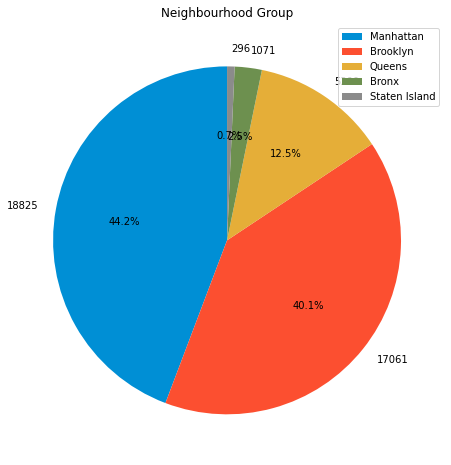

In [ ]:
labels = data.neighbourhood_group_cleansed.value_counts().index
colors = ['#008fd5','#fc4f30','#e5ae38','#6d904f','#8b8b8b']

shape = data.neighbourhood_group_cleansed.value_counts().values

plt.figure(figsize=(8,8))
plt.pie(shape, labels=shape, colors= colors, autopct = '%1.1f%%', startangle=90)
plt.legend(labels)
plt.title('Neighbourhood Group')
plt.show()

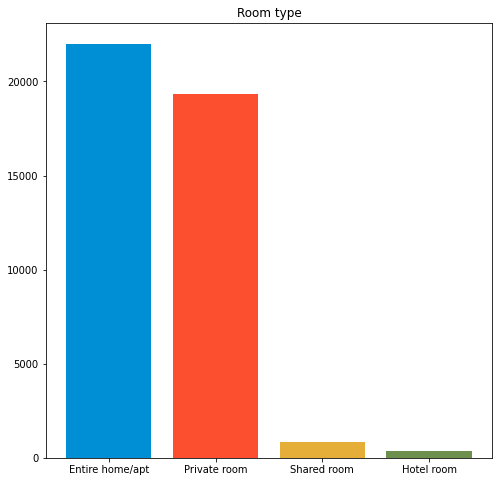

In [ ]:
labels = data.room_type.value_counts().index

colors = ['#008fd5','#fc4f30','#e5ae38','#6d904f']

shape = data.room_type.value_counts().values

plt.figure(figsize=(8,8))
plt.bar(labels, shape, color=colors)
plt.title('Room type')
plt.show()

In [ ]:
coord = data.loc[:,['longitude','latitude']]
coord.describe()

,longitude,latitude
count,42553.0000,42553.0000
mean,-73.9509,40.7296
std,0.0473,0.0550
min,-74.2399,40.5087
25%,-73.9830,40.6897
50%,-73.9554,40.7244
75%,-73.9343,40.7634
max,-73.7119,40.9117


In [ ]:
import folium
from folium.plugins import HeatMap
# convert to (n, 2) nd-array format for heatmap

map_folium = folium.Map([40.715076, -73.991180],zoom_start=11.4)

HeatMap(data[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(map_folium)
display(map_folium)


RecursionError: ignored

In [ ]:
data.host_response_time.unique()

NameError: ignored